In [1]:
%load_ext autoreload
%autoreload 2

### Preview of dask-backed radar processing interface

Most of the core code is packaged into `processing_dask.py`, so that file is worth a browse.

In the immediate future, the core advantage is dask's ability to automatically chunk data such
that small chunks of giant files can be processed without running out of memory. To facilitate this,
you can set a memory limit in the next cell. Dask will process chunks until it runs against this
limit and then start storing already-completed results to disk.

In the longer term, this infrastructure should also allow us to do some other fun tricks, such as
storing out data in cloud storage buckets and automatically farming out computations to
SLURM-managed clusters (i.e. Sherlock) or cloud compute services.

There are some new dependencies:
* xarray
* dask
* zarr
* hvplot
* datashader

The last two are technically only needed for plotting (more about that below).

In [2]:
# This setup activates the "distributed" scheduler. In this case, we're still running it locally, but this gives us access to additional features (i.e. memory limits).
# See https://docs.dask.org/en/stable/scheduling.html
from dask.distributed import Client, LocalCluster
client = Client(n_workers=1,
                threads_per_worker=1,
                memory_limit='20GB') # Note that `memory_limit` is the limit **per worker**.
client # If you click the dashboard link in the output, you can monitor real-time progress and get other cool visualizations.

/home/dfxmay/miniconda3/envs/sdr/lib/python3.8/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45487 instead
  warnings.warn(
2023-08-23 14:35:41,155 - distributed.nanny.memory - WARNING - Ignoring provided memory limit 20GB due to system memory limit of 15.38 GiB


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:45487/status,
Dashboard: http://127.0.0.1:45487/status,Workers: 1
Total threads: 1,Total memory: 15.38 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39281,Workers: 1
Dashboard: http://127.0.0.1:45487/status,Total threads: 1
Started: Just now,Total memory: 15.38 GiB
Comm: tcp://127.0.0.1:40869,Total threads: 1
Dashboard: http://127.0.0.1:42669/status,Memory: 15.38 GiB
Nanny: tcp://127.0.0.1:40773,


In [3]:
import copy
import sys
import xarray as xr
import numpy as np
import dask.array as da

import matplotlib.pyplot as plt
import hvplot.xarray
import scipy.constants

sys.path.append("..")
import processing_dask as pr
import plot_dask
import processing as old_processing

sys.path.append("../../preprocessing/")
from generate_chirp import generate_chirp

In [4]:
#prefix = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20230621-bench-prf-testing/20230621_163428"
#prefix = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20230621-bench-prf/20230622_104230"
#prefix = "/home/thomas/Documents/StanfordGrad/RadioGlaciology/drone/radar_data/20230621-bench-prf/20230621_173826"
#prefix = "/Users/abroome/Documents/SDR/uhd_radar/data/20230626_143830"
prefix = "/home/dfxmay/Projects/uhd_radar-1/data/20230823_140310"

zero_sample_idx = 159
#zero_sample_idx = 36

#zarr_path = pr.save_radar_data_to_zarr(prefix, zarr_base_location="/home/thomas/Documents/StanfordGrad/RadioGlaciology/test_tmp_zarr_cache/", skip_if_cached=False)
zarr_path = pr.save_radar_data_to_zarr(prefix, zarr_base_location="/home/dfxmay/Documents/test_tmp_zarr_cache/", skip_if_cached=False)

zarr_path

/home/dfxmay/miniconda3/envs/sdr/lib/python3.8/site-packages/dask/base.py:1368: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


'/home/dfxmay/Documents/test_tmp_zarr_cache/20230823_140310.zarr'

In [5]:
raw = xr.open_zarr(zarr_path)

#raw # Uncomment this to explore the structure of the resulting dataset

If you're new to xarray, it's probably worth a read through some of their intro docs: https://docs.xarray.dev/en/stable/getting-started-guide/quick-overview.html

The dataset has a single "data variable" called `radar_data` (and I think we should keep it this way).

In addition to the data variable, there are dimensions, coordinates, and attributes.

Dimensions are just names for the indices into the data variables. You can see them above under "indexes". For us, they are `pulse_idx` and `sample_idx`.

Coordinates are variables associated to one or more dimensions that are sort of like metadata. In our case, we have `pulse_idx`, `slow_time`, `sample_idx`, and `fast_time`. Coordinates that have the same name as a dimension are considered "dimension coordinates" and can be directly used for indexing. You can only have one dimension coordinate per dimension, but you can easily swap which coordinate is the dimension coordinate with `swap_dims()` (see, for example, the second plotting example).

More about this here: https://docs.xarray.dev/en/stable/user-guide/data-structures.html#coordinates

Attributes serves as a dictionary of random other stuff you can package with your dataset. I've put the config and log output there. For example, you can access anything from the associated config YAML like this:

`raw.attrs['config']['GENERATE']['sample_rate']`

In [6]:
stacked = pr.remove_errors(raw)
stacked = pr.stack(stacked,10)

In [7]:
config_blackman_window = copy.deepcopy(stacked.config)
config_blackman_window['GENERATE']['window'] = 'rectangular'

chirp_ts, chirp = generate_chirp(config_blackman_window)
compressed = pr.pulse_compress(stacked, chirp,
                               fs=stacked.config['GENERATE']['sample_rate'],
                               zero_sample_idx=zero_sample_idx,
                               signal_speed=scipy.constants.c * (2/3))

In [32]:
print(compressed.reflection_distance[0])

print(compressed.reflection_distance[-1])
print(compressed.sel(travel_time=12e-6, method='nearest'))

<xarray.DataArray 'reflection_distance' ()>
array(-283.85881389)
Coordinates:
    travel_time          float64 -2.841e-06
    reflection_distance  float64 -283.9
<xarray.DataArray 'reflection_distance' ()>
array(3715.15843836)
Coordinates:
    travel_time          float64 3.718e-05
    reflection_distance  float64 3.715e+03
<xarray.Dataset>
Dimensions:              (pulse_idx: 1000)
Coordinates:
  * pulse_idx            (pulse_idx) int64 0 10 20 30 40 ... 9960 9970 9980 9990
    slow_time            (pulse_idx) float64 dask.array<chunksize=(1000,), meta=np.ndarray>
    travel_time          float64 1.201e-05
    reflection_distance  float64 1.2e+03
Data variables:
    radar_data           (pulse_idx) complex64 dask.array<chunksize=(10,), meta=np.ndarray>
Attributes:
    pulse_compress:  {'fs': 56000000.0, 'chirp': array([ 1.        +0.j      ...


Everything has run quickly up to now because (apart from the data translation to zarr) no actual data has been processed.


When you actually request data (by calling `.compute()` on it), the processing actually begins. Plotting triggers this process.

In [21]:
raw.radar_data[50,50].compute()

<xarray.DataArray 'radar_data' ()>
array(0.00053555-0.00043595j, dtype=complex64)
Coordinates:
    fast_time   float64 8.931e-07
    pulse_idx   int64 50
    sample_idx  int64 50
    slow_time   float64 0.025
Attributes:
    description:  complex radar data

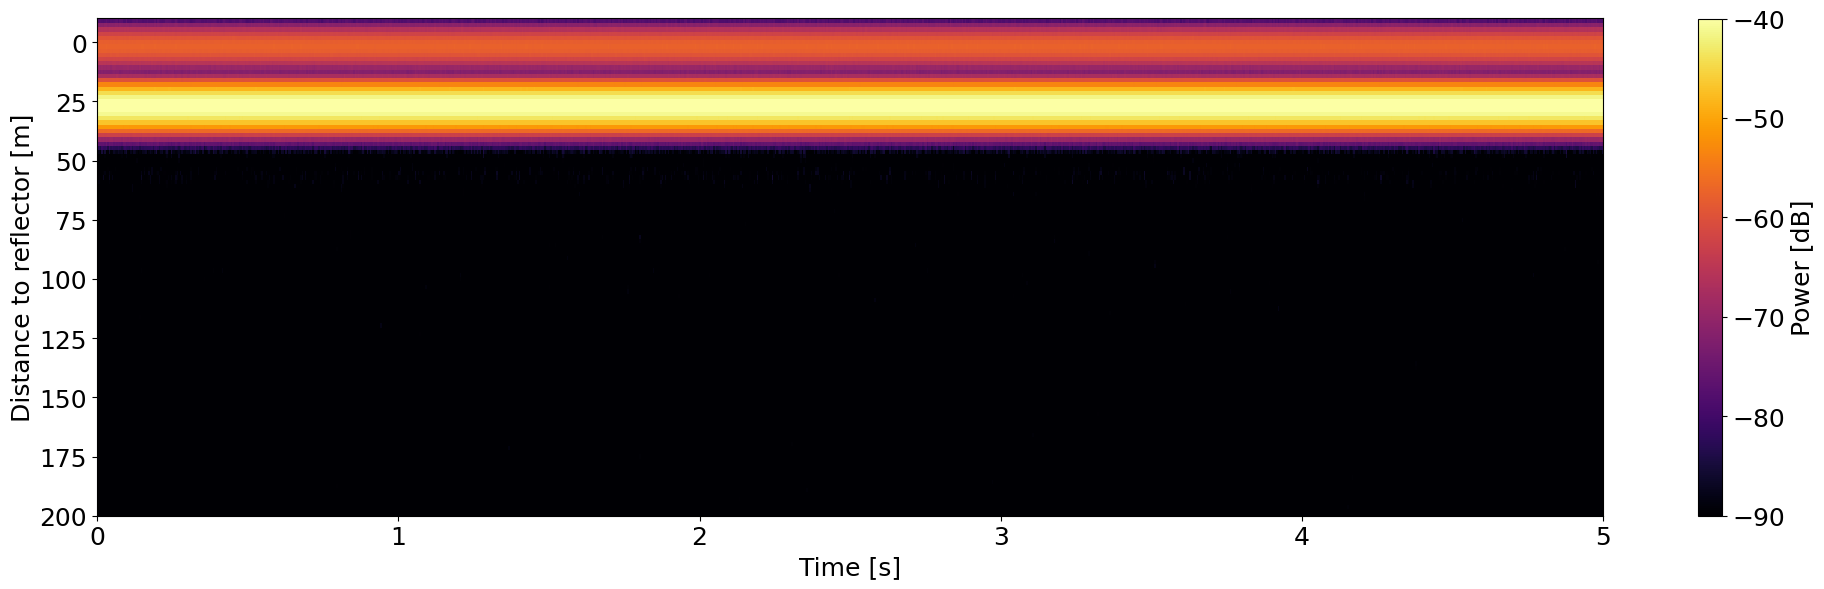

In [8]:
# This roughly matches the old plot_radargram function I was using and uses matplotlib
plot_dask.plot_radargram(compressed, sig_speed=scipy.constants.c * (2/3), figsize=(20,6), vmin=-90, vmax=-40, ylims=(200, -10))
plt.show()

In [ ]:
# Here's an example of a parallelizable implementation of log compression
return_power = xr.apply_ufunc(
    lambda x: 20*np.log10(np.abs(x)),
    compressed,
    dask="parallelized"
)

In [ ]:
# If you expect to repeatedly need the same data, you can explicitly tell dask to keep it around in memory.
#return_power.persist()

In [ ]:
# Example of plotting using hvplot -- this is supposed to be more efficient at directly plotting giant datasets
# I haven't really dug into this much yet, but there's documentation here: https://holoviews.org/user_guide/Large_Data.html
# In the backend, this uses bokeh, so the plots are also interactive
return_power.swap_dims({'pulse_idx': 'slow_time', 'travel_time': 'reflection_distance'}).hvplot.quadmesh(x='slow_time', ylim=(100,-50), clim=(-90,-40), cmap='inferno')

## Spectrum visualization

In [ ]:
inpt = pr.remove_errors(raw)
inpt["radar_data"].shape

In [ ]:
n = 200
pulse = pr.stack(inpt, n)[{'pulse_idx':0}]["radar_data"].to_numpy()

f, t, S = scipy.signal.spectrogram(
    pulse,
    fs=raw.attrs["config"]["GENERATE"]["sample_rate"],
    window='flattop',
    nperseg=100,
    scaling='density', mode='psd',
    return_onesided=False
)

fig, ax = plt.subplots(facecolor='white', figsize=(10,6))
freq_mhz = (np.fft.fftshift(f) + inpt.attrs['config']['RF0']['freq']) / 1e6
pcm = ax.pcolormesh(t, freq_mhz, 20*np.log10(np.abs(np.fft.fftshift(S, axes=0))), shading='nearest', vmin=-420, vmax=-200)
clb = fig.colorbar(pcm, ax=ax)
clb.set_label('Power [dB]')
ax.set_xlabel('Time [s]')
ax.set_ylabel('Frequency [MHz]')
ax.set_title(f"Spectrogram of received data with n_stack={n}")